## Exploratory Data Analysis of The Transformed Loan Payments Table

In [1]:
# Import necessary modules

from data_frame_info import DataFrameInfo

from plotter import Plotter

from db_connector import open_null_removed_table

In [2]:
# Call the open_latest_table function and retrieve the final transformed loan payments dataframe.
loan_payments = open_null_removed_table()

In [3]:
# Call the DataFrameInfo class
table_info = DataFrameInfo(loan_payments)

# Calculate percentage loans recovered against total loans and total loan investments.
loan_recoveries = table_info.recovered_loans()

The proportion of loan investments recovered is 78.73%.
The proportion of whole loans recovered is 79.16%.
6 months of customer instalments will result in 18.14% loan recovery.


### Plot the percentage loan recoveries.

<BarContainer object of 3 artists>

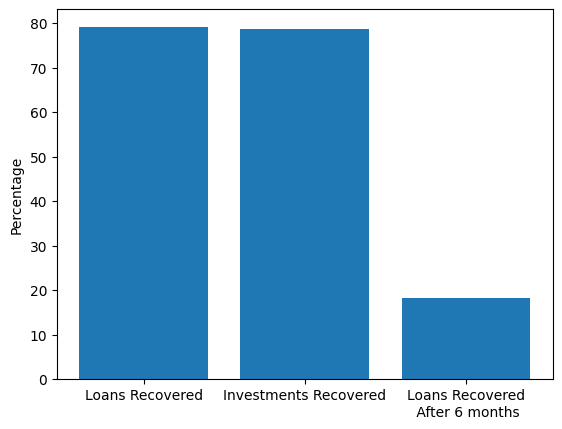

In [4]:
# Call the Plotter class
plot_data = Plotter(loan_payments)

# Plot a bar chart of percentage loan recoveries using loan_recoveries.
plot_data.bar_chart(loan_recoveries)

### Calculating loss.

In [5]:
# Call the get_unique_values method to find unique values in the 'loan_status column.
loan_status = table_info.get_unique_values('loan_status')
display(loan_status)

# Calculate the percentage loss to the company as per 'Charged Off' loans.
total_loans = (loan_status.sum())
charged_off = loan_status['Charged Off']
percentage_loss = (charged_off / total_loans * 100).round(2)
print(f'The number of charged off loans are {charged_off}, which equates to a {percentage_loss}% loss for the company.')

# Isolate rows with 'charged_off' loans.
charged_off_loans = loan_payments.loc[loan_payments['loan_status'] == 'Charged Off']

# Calculate amount paid off towards charged off loans.
charged_off_payments = (charged_off_loans['total_payment'].sum()).round(2)
print(f'A total of {charged_off_payments} was paid towards charged off loans')

loan_status
Fully Paid                                             27033
Current                                                19267
Charged Off                                             5503
Does not meet the credit policy. Status:Fully Paid       984
Late (31-120 days)                                       580
Does not meet the credit policy. Status:Charged Off      361
In Grace Period                                          265
Late (16-30 days)                                        106
Default                                                   52
Name: count, dtype: int64

The number of charged off loans are 5503, which equates to a 10.16% loss for the company.
A total of 37305414.56 was paid towards charged off loans


In [6]:
# Call the DataFrameInfo class with the charged off subset of the loan payments table.
charged_off_info = DataFrameInfo(charged_off_loans)

# View different term length (months) of charged off loans.
loan_terms = charged_off_info.get_unique_values('term')
print(loan_terms)

# Isolate 36 and 60 month term loans.
term_36_loans = loan_payments.loc[loan_payments['term'] == 36.0]
term_60_loans = loan_payments.loc[loan_payments['term'] == 60.0]

# Calculate amount due over whole term of charged of loans.
term_36_owed = term_36_loans['instalment'].sum() * 36
term_60_owed = term_60_loans['instalment'].sum() * 36

# Calculate potential revenue from charged off loans if they were to have been paid off in full over whole term.
projected_loss = (term_36_owed + term_60_owed).round(2)
print(f'Upon completion of all loan terms the company had the potentional to receive {projected_loss} from charged off loans if they were to have been paid off in full.')

# Calculate projected loss inclusive of payments already made towards charged off loans.
real_loss = projected_loss - charged_off_payments


term
36.0    3517
60.0    1986
Name: count, dtype: int64
Upon completion of all loan terms the company had the potentional to receive 780086392.56 from charged off loans if they were to have been paid off in full.


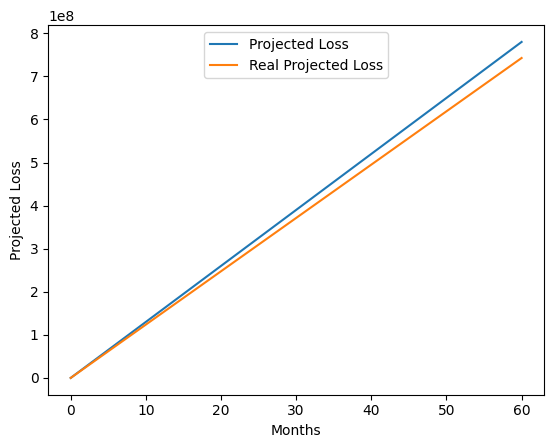

In [7]:
# Visualise projected loss using line graph.
plot_data.line_graph(projected_loss, real_loss)

### Calculating possible loss.

In [8]:
# Isolate rows of loan payments table for loans with overdue payment deadlines.
late_loans = loan_payments.loc[loan_payments['loan_status'].isin(['Late (16-30 days)', 'Late (31-120 days)', 'Default'])]

# Calculate percentage of loans which are overdue.
total_loans = len(loan_payments['loan_amount'])
total_late_loans = len(late_loans['loan_amount'])
percentage_late = (total_late_loans / total_loans * 100)
print(f'{percentage_late}% of all loans are overdue.')

# Calculate total number of customers with overdue loans.
late_customers = late_loans['member_id'].nunique()
print(f'The total number of customers with overdue loans is {late_customers}.')

# Calculate loss to company if all late loans are charged off.
possible_loss = late_loans['out_prncp'].sum()
print(f'The possible loss the company could incur if all overdue loans are charged off is {possible_loss}.')

# Calculate projected loss (inclusive of interest) after loan term completion.
predicted_revenue = (late_loans['instalment'] * late_loans['term']).sum().round(2)
projected_loss = predicted_revenue - late_loans['total_payment'].sum()
print(f'The projected loss on overdue loans (inclusive of interest) upon term completion without further repayment is {projected_loss}.')

# Calculate the percentage of overdue loans based on the total loan amount.
total_loan_amount = loan_payments['funded_amount'].sum()
total_late_loan_amount = late_loans['funded_amount'].sum()
percentage_amount_late = (total_late_loan_amount / total_loan_amount * 100).round(2)
print(f'The proportion of the total loan amount which is linked to overdue loans is {percentage_amount_late}%')

1.3628557182692842% of all loans are overdue.
The total number of customers with overdue loans is 738.
The possible loss the company could incur if all overdue loans are charged off is 6471565.41.
The projected loss on overdue loans (inclusive of interest) upon term completion without further repayment is 7861000.97.
The proportion of the total loan amount which is linked to overdue loans is 1.53%


### Predicting loss by potential predictors.

In [9]:
# Parameters which may affect risk of non-repayment.
risk_factors = ['grade', 'purpose', 'home_ownership']

# View range of categories within the risk factor columns.
risk_categories = table_info.get_unique_values(risk_factors)
display(risk_categories)

# Isolate rows for customers who are on track with their loan payments.
on_track_loans = loan_payments.loc[loan_payments['loan_status'] == 'Current']

# Isolate rows for customers who have stopped paying their loans.
unpaid_loans = loan_payments.loc[loan_payments['loan_status'] == 'Charged Off']

grade  purpose             home_ownership
B      debt_consolidation  MORTGAGE          4425
C      debt_consolidation  MORTGAGE          3861
B      debt_consolidation  RENT              3686
C      debt_consolidation  RENT              3495
A      debt_consolidation  MORTGAGE          2542
                                             ... 
G      debt_consolidation  OTHER                1
       educational         MORTGAGE             1
                           RENT                 1
D      moving              OTHER                1
                           OWN                  1
Name: count, Length: 319, dtype: int64

In [10]:
# Test for statistical significance between potential risk factors and loan status for all customers via chi-square.
print('All customers:')
table_info.chi_square_test(loan_payments, risk_factors)

# Perform the Chi-square test for a subset of customers who are on track with their loans.
print('\nOn track loan customers:')
table_info.chi_square_test(on_track_loans, risk_factors)

# Perform the Chi-square test for a subset of customers who are behind on loan payments.
print('\nLate loan customers:')
table_info.chi_square_test(late_loans, risk_factors)

# Perform the Chi-square test for a subset of customers who have stopped paying their loans.
print('\nCharged off loan customers:')
table_info.chi_square_test(unpaid_loans, risk_factors)

All customers:
Statistical comparison between grade and loan_status provides a Chi-square statistic of 3768.3508067318576 and a p-value of 0.0
Statistical comparison between purpose and loan_status provides a Chi-square statistic of 2549.9599015611675 and a p-value of 0.0
Statistical comparison between home_ownership and loan_status provides a Chi-square statistic of 575.7412830265265 and a p-value of 5.942698021647332e-101

On track loan customers:
Statistical comparison between grade and loan_status provides a Chi-square statistic of 0.0 and a p-value of 1.0
Statistical comparison between purpose and loan_status provides a Chi-square statistic of 0.0 and a p-value of 1.0
Statistical comparison between home_ownership and loan_status provides a Chi-square statistic of 0.0 and a p-value of 1.0

Late loan customers:
Statistical comparison between grade and loan_status provides a Chi-square statistic of 10.524932621286814 and a p-value of 0.5700092381283908
Statistical comparison between 

,Risk Factor,Chi-square Statistic,p-value
0,grade,0.0,1.0
1,purpose,0.0,1.0
2,home_ownership,0.0,1.0


<Axes: >

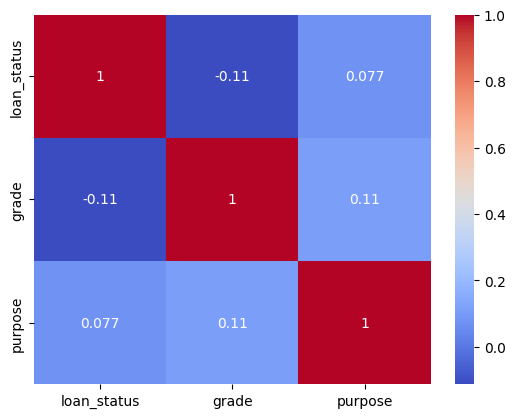

In [16]:
# Produce heatmap for correlated columns relating to loan payment risk.
correlated_columns = ['loan_status', 'grade', 'purpose']
plot_data.heat_map(correlated_columns)